Welcome! This is a tutorial to guide you through the basic steps required to calibrate your radar scanner using the sun.

Primer:
You can follow this tutorial as a standalone guide. However, to understand the background of the procedures we are going to perform, it would also be helpful to read the corresponding publication ().
One especially important point is the difference between positions in the sky and axis positions of your scanner. In general, the value you get from the "azimuth" axis of your scanner is not equal to the actual azimuth value of the radar beam in the sky (and similar for elevation). They would be the same only for a perfectly oriented scanner. Therefore, we are going to denote the vertical axis of the scanner as $\gamma$ (`gamma`) and the horizontal axis as $\omega$ (`omega`). Actual celestial positions are denoted as $\phi$ (`azi`) for azimuth and as $\theta$ (`elv`) for elevation. In our convention, $\phi=0$ means North and $\theta=90$ means vertical. Unless stated otherwise, all angles are in degrees.

As a first step, create a sky object. For a given location, it allows you to calculate the apparent positions of the sun in the sky. This includes a correction for the change in solar elevation due to refraction in the microwave regime.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sunscan as sc

sky=sc.SunObject(
    lat=48.148,
    lon=11.573,
    altitude=538,
    refraction_correction=True,
    humidity=0.5
)
sun_azi, sun_elv=sky.compute_sun_location(t='now')
print(f'Sun azimuth: {sun_azi:.2f} degrees, Sun elevation: {sun_elv:.2f} degrees')

2025-11-16 14:34:21,405 - sunscan - INFO - Initialized SunObject with location lat: 48.148, lon: 11.573, altitude: 538, refraction_correction: True, humidity: 0.5


Sun azimuth: 217.91 degrees, Sun elevation: 14.54 degrees


Using the position of the sun, you can start to perform a sunscan. Pointing your radar into the region of the sky where the sun is located, you will receive the sun's microwave emission. Try to get samples from all regions of the solar disk and it's immediate vicinity. Usually, +- 1 degree is enough, but this depends on how well your radar is already calibrated. Ideally, you also try to move your scanner with different azimuth directions and speeds across the sun. This will help us to estimate the backlash of the scanner, as well as the time offset between the recording of received signal and axis position. Other than this, the exact pattern you perform does not matter. Often, a square or rhomb pattern around the expected sun position is used (but if you feel fancy, a spiral would do just as well).


After you finished your scan, please prepare the data from your radar in the form of six 1D (numpy) arrays:
- `time`: The time in UTC, ideally in the form of a numpy.datetime64 array.
- `gamma`: The "azimuth" position of your scanner in degrees.
- `omega`: The "elevation" position of your scanner in degrees.
- `gammav`: The "azimuth" speed of your scanner in degrees/second.
- `omegav`: The "elevation" speed of your scanner in degrees/second.
- `signal`: The receiver signal strength in dB. Depending on your radar, you might have to turn of some filters or look into the noise channel to see the actual sun signal.

Here, we are going to load some example data from the sunscan module.

In [2]:
from sunscan.examples import load_example_sunscan
ds= load_example_sunscan('sunscan1.nc')
gamma=ds.gamma.values
omega=ds.omega.values
time=ds.time.values
radar_signal=ds.sun_signal.values
gammav=ds.gammav.values
omegav=ds.omegav.values

At first, make a simple plot of your data. The sun should be visible as a blurry, sometimes elongated maximum above the noise floor.

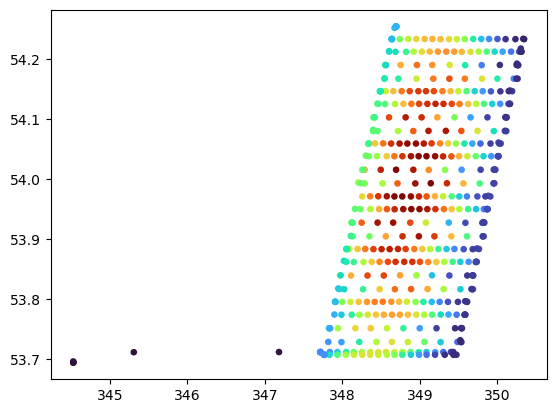

In [3]:
plt.scatter(gamma, omega, c=radar_signal, s=14, cmap='turbo')

Since our scanning pattern takes the movement of the sun into account, the points are distributed within a rhomb shaped area. As mentioned, this shape is not important. Due to the different movement speeds, some rows in the plot above are dense, while others are more sparse.

If you can see the sun in the data, you are ready to proceed. Create a `SunSimulationEstimator` object. Using this object, we will try to replicate your data as good as possible, thereby deriving the following parameters:
- `dgamma`: The local mispointing of your radar in azimuth direction in this region of the sky in degrees.
- `domega`: The local mispointing of your radar in elevation direction in this region of the sky in degrees.
- `fwhm_x`: The full-width half maximum of the antenna main lobe in azimuth direction in degrees.
- `fwhm_y`: The full-width half maximum of the antenna main lobe in elevation direction in degrees.
- `dtime`: The time offset between the recording of the signal strength and the scanner position in seconds.
- `backlash_gamma`: The backlash for the gamma axis in degrees. 

You can specify which of those parameters the optimizer should be allowed to vary, the range for the variation and the starting values. The following might be good starting values:

In [4]:
params_optimize = ['dgamma', 'domega', 'fwhm_x', 'fwhm_y', 'dtime', 'backlash_gamma']
params_guess = {
        'dgamma': None, #in this case, the starting value will be initialized based on the position of the maximum in the data
        'domega': None,
        'fwhm_x': 0.6,
        'fwhm_y': 0.6,
        'dtime': 0.0,
        'backlash_gamma': 0.0,
    }
params_bounds = {
        'dgamma': (-0.5, 0.5),
        'domega': (-0.5, 0.5),
        'fwhm_x': (-0.3, 0.3), # bounds are always relative to the initial guess
        'fwhm_y': (-0.3, 0.3),
        'dtime': (-1.0, 1.0),
        'backlash_gamma': (-0.2, 0.2),
    }

In [5]:
estimator=sc.SignalSimulationEstimator(sun=sky, 
                                    params_optimize=params_optimize,
                                    params_guess=params_guess,
                                    params_bounds=params_bounds)

The first time you call this function, this can take a while, since a new lookup table will be created.

In [6]:
simulator, rmse=estimator.fit(gamma, omega, time, radar_signal, gammav, omegav, brute_force=True, brute_force_points=3)
print("The final parameters are:")
print(simulator)

2025-11-16 14:34:37,369 - sunscan - INFO - Loading lookup table from /home/p/Paul.Ockenfuss/Work/Software/PythonPackages/sunscan/data/lut.nc.


2025-11-16 14:34:37,462 - sunscan - INFO - Estimated dgamma: 203.0603, domega: -0.0021
2025-11-16 14:34:42,192 - sunscan - INFO - Brute force optimization enabled with 3 points (729 total)
2025-11-16 14:34:52,433 - sunscan - INFO - Best Parameters: 203.0603, -0.0021, 0.6000, 0.4500, 0.0000, -0.1000, 1.0000
2025-11-16 14:34:52,434 - sunscan - INFO - Best RMSE: 0.364337
2025-11-16 14:34:52,434 - sunscan - INFO - Brute force did improve the initial guess from 0.569923 to 0.364337
2025-11-16 14:35:05,508 - sunscan - INFO - Optimization Result:
dgamma: 202.9727
domega: -0.0294
fwhm_x: 0.5380
fwhm_y: 0.5343
dtime: -0.3097
backlash_gamma: -0.0042
limb_darkening: 1.0000
2025-11-16 14:35:05,523 - sunscan - INFO - Initial objective: 0.364337
2025-11-16 14:35:05,524 - sunscan - INFO - Optimal objective: 0.095551


The final parameters are:
Sun Simulator Object:
Azimuth Offset: 202.9727 º
Elevation Offset: -0.0294 º
Time Offset: -0.3097 º
Beamwidth cross-elevation: 0.5380 º
Beamwidth co-elevation: 0.5343 º
Azimuth Backlash: -0.0042 º
Limb Darkening factor: 1.0000
Sky/Noise: 0.4427 [lin. units]
Sun Brightness: 1.4718 [lin. units]



The result is a signal simulator object. For a given scanner position, it can simulate the expected sun signal in your receiver, taking into account the local mispointing, beamshape and offsets. Let's see if the simulated signal matches the measurements:

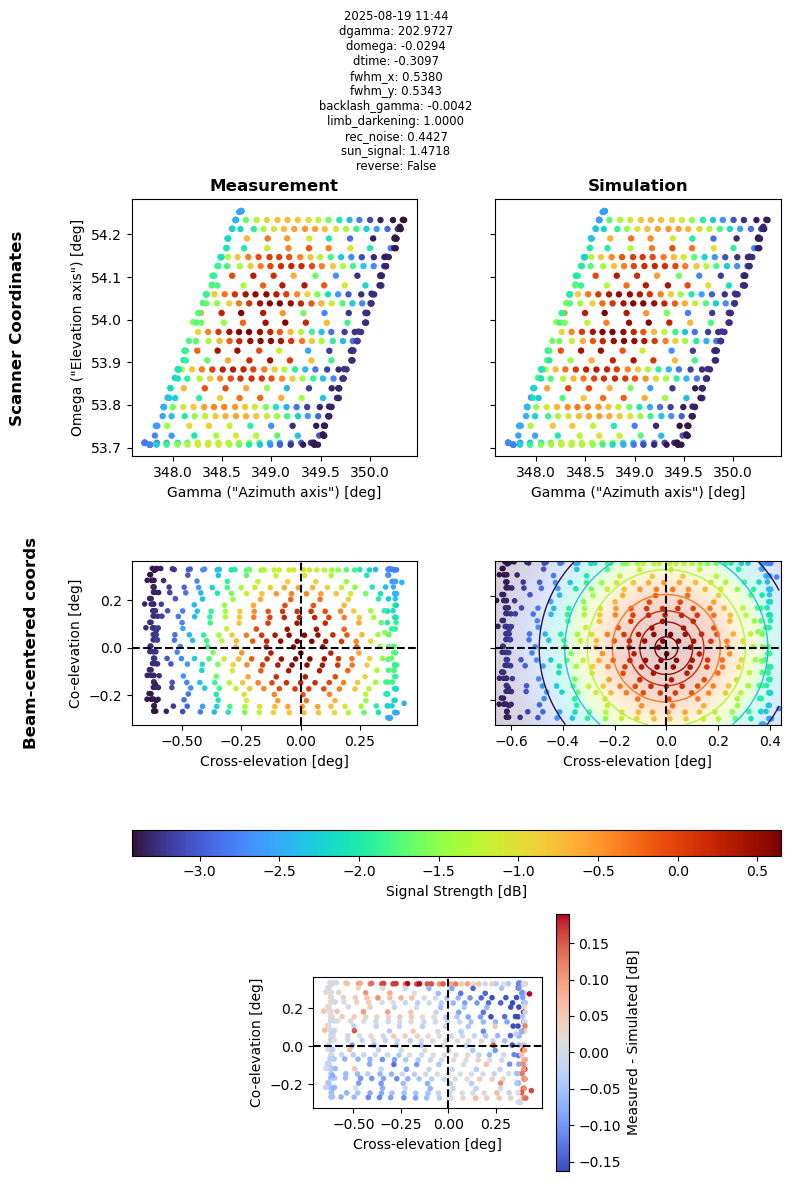

In [7]:
from sunscan.plotting import plot_sunscan_simulation
fig, axs= plot_sunscan_simulation(simulator, gamma, omega, time, radar_signal, gammav, omegav, sun=sky, remove_outliers=True)

In this plot, the left column shows the measured signal strength, the right column shows the simulated signal (normalized between 0 and 1). The first row shows the samples as delivered from the scanner in gamma-omega space. The second and third row show the expected sun position in beam-centered coordinates. In beam-centered coordinates, the position of a dot shows where we expect the sun to be, in relation to the beam. If the maximum signal is not around (0,0) in these coordinates, we know that there is some uncorrected mispointing. Since this is not the case and the simulation looks almost identical to the measurement, the fit has worked and we know the local mispointing of our scanner in this region of the sky.
Finally, we can calculate a calibrated pair of coordinates, consisting of a scanner position $(\gamma_s, \omega_s)$ and the exact corresponding pointing $(\phi_b, \theta_b)$ in the sky. Save those values somewhere on disk and you are done with part 1!

In [8]:
gamma_s, omega_s, azi_beam, elv_beam=simulator.get_calibrated_pair(gamma, omega, time)
print(f"In this region of the sky:\ngamma = {gamma_s:.4f} maps to azimuth   = {azi_beam:.4f}\nomega = {omega_s:.4f}  maps to elevation = {elv_beam:.4f}")

In this region of the sky:
gamma = 348.8346 maps to azimuth   = 191.8073
omega = 54.0007  maps to elevation = 53.9714
